In [1]:
import cv2
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from skimage.feature import peak_local_max
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.models import Sequential
from keras.initializers import RandomNormal
from keras.optimizers import SGD
from keras import backend as K
from keras.saving import register_keras_serializable
from tensorflow.keras.models import load_model


In [2]:
@register_keras_serializable()
class CSRNet:
    def __init__(self):
        self.model = self.build_model()

    def build_model(self):
        kernel = (3, 3)
        init = RandomNormal(stddev=0.01)
        model = Sequential()

        # Frontend (VGG-16)
        model.add(Conv2D(64, kernel_size=kernel, activation='relu', padding='same', input_shape=(None, None, 3), kernel_initializer=init))
        model.add(Conv2D(64, kernel_size=kernel, activation='relu', padding='same', kernel_initializer=init))
        model.add(MaxPooling2D(strides=2))

        model.add(Conv2D(128, kernel_size=kernel, activation='relu', padding='same', kernel_initializer=init))
        model.add(Conv2D(128, kernel_size=kernel, activation='relu', padding='same', kernel_initializer=init))
        model.add(MaxPooling2D(strides=2))

        model.add(Conv2D(256, kernel_size=kernel, activation='relu', padding='same', kernel_initializer=init))
        model.add(Conv2D(256, kernel_size=kernel, activation='relu', padding='same', kernel_initializer=init))
        model.add(Conv2D(256, kernel_size=kernel, activation='relu', padding='same', kernel_initializer=init))
        model.add(MaxPooling2D(strides=2))

        model.add(Conv2D(512, kernel_size=kernel, activation='relu', padding='same', kernel_initializer=init))
        model.add(Conv2D(512, kernel_size=kernel, activation='relu', padding='same', kernel_initializer=init))
        model.add(Conv2D(512, kernel_size=kernel, activation='relu', padding='same', kernel_initializer=init))

        # Backend (Dilated Convolutions)
        model.add(Conv2D(512, kernel_size=kernel, activation='relu', dilation_rate=2, padding='same', kernel_initializer=init))
        model.add(Conv2D(512, kernel_size=kernel, activation='relu', dilation_rate=2, padding='same', kernel_initializer=init))
        model.add(Conv2D(512, kernel_size=kernel, activation='relu', dilation_rate=2, padding='same', kernel_initializer=init))
        model.add(Conv2D(256, kernel_size=kernel, activation='relu', dilation_rate=2, padding='same', kernel_initializer=init))
        model.add(Conv2D(128, kernel_size=kernel, activation='relu', dilation_rate=2, padding='same', kernel_initializer=init))
        model.add(Conv2D(64, kernel_size=kernel, activation='relu', dilation_rate=2, padding='same', kernel_initializer=init))
        model.add(Conv2D(1, kernel_size=(1, 1), activation='relu', padding='same', kernel_initializer=init))

        # Compile the model
        sgd = SGD(learning_rate=1e-7, decay=5e-4, momentum=0.95)
        model.compile(optimizer=sgd, loss=self.euclidean_distance_loss, metrics=['mse'])

        return model

    def euclidean_distance_loss(self, y_true, y_pred):
        return K.sqrt(K.sum(K.square(y_pred - y_true), axis=-1))

    def load_weights(self, weight_path):
        self.model.load_weights(weight_path)

    def predict(self, image):
        return self.model.predict(image)

    def get_config(self):
        return {"name": self.__class__.__name__}


In [3]:
# Preprocess the input image
def preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')
    image = np.array(image)
    image = image / 255.0
    image[:, :, 0] = (image[:, :, 0] - 0.485) / 0.229
    image[:, :, 1] = (image[:, :, 1] - 0.456) / 0.224
    image[:, :, 2] = (image[:, :, 2] - 0.406) / 0.225
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    return image

# Detect peaks in the density map
def detect_peaks(density_map):
    peaks = peak_local_max(density_map, min_distance=1, threshold_rel=0.019)
    return peaks, len(peaks)

# Overlay numbers on the image
def overlay_numbers(image, peaks, original_shape, density_map_shape):
    # Calculate the scaling factors
    scale_x = original_shape[1] / density_map_shape[1]
    scale_y = original_shape[0] / density_map_shape[0]

    for i, peak in enumerate(peaks):
        x, y = peak
        # Scale the coordinates
        x = int(x * scale_y)
        y = int(y * scale_x)
        # Add text with a black outline for better readability
        cv2.putText(image, str(i+1), (y, x), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 3)  # Black outline
        cv2.putText(image, str(i+1), (y, x), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)  # Red text
    return image

# Process an image
def process_image(model, image_path):
    preprocessed_image = preprocess_image(image_path)
    density_map = model.predict(preprocessed_image).squeeze()
    peaks, num_peaks = detect_peaks(density_map)
    original_image = cv2.imread(image_path)
    numbered_image = overlay_numbers(original_image, peaks, original_image.shape, density_map.shape)
    return numbered_image


# Process a video
def process_video(model, video_path):
    cap = cv2.VideoCapture(video_path)
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        preprocessed_image = preprocess_image(image)
        density_map = model.predict(preprocessed_image).squeeze()
        peaks = detect_peaks(density_map)
        numbered_frame = overlay_numbers(frame, peaks)
        cv2.imshow('Numbered Crowd', numbered_frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

# Process a live stream from a camera
def process_live_stream(model, camera_index=0):
    cap = cv2.VideoCapture(camera_index)
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        preprocessed_image = preprocess_image(image)
        density_map = model.predict(preprocessed_image).squeeze()
        peaks = detect_peaks(density_map)
        numbered_frame = overlay_numbers(frame, peaks)
        cv2.imshow('Numbered Crowd', numbered_frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

# Main function to determine input type and process accordingly
def main(model, input_path):
    if input_path.endswith(('.jpg', '.jpeg', '.png')):
        numbered_image = process_image(model, input_path)
        numbered_image = cv2.cvtColor(numbered_image, cv2.COLOR_BGR2RGB)
        plt.imshow(numbered_image)
    elif input_path.endswith(('.mp4', '.avi', '.mov')):
        process_video(model, input_path)
    elif input_path == 'camera':
        process_live_stream(model)
    else:
        logging.error("Unsupported input type. Please provide an image, video, or 'camera' for live stream.")
        print("Unsupported input type. Please provide an image, video, or 'camera' for live stream.")



In [4]:
model = CSRNet()
model.load_weights("/kaggle/input/crowdcount-data/model_A_weights.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


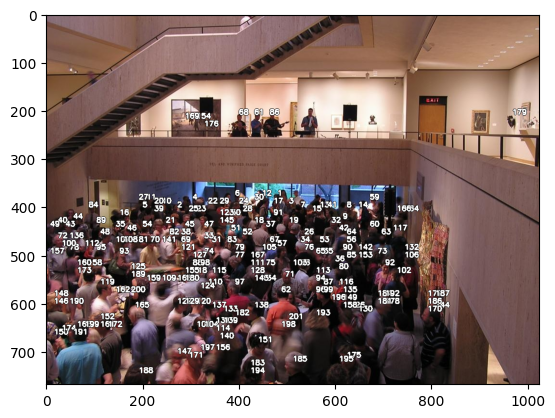

In [5]:
input_path="/kaggle/input/crowdcount-data/Dataset/images/train/IMG_102A-train.jpg"
prediction=main(model, input_path)

In [ ]:
pip install ultralytics

In [ ]:
import torch
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, LeakyReLU, Add, Input, ZeroPadding2D, UpSampling2D, Concatenate, Activation
from tensorflow.keras.models import Model
from ultralytics import YOLO

# Load the YOLO11n model using ultralytics
pytorch_model = YOLO("/kaggle/input/csrnet-weights/yolo11n.pt")

# Define the YOLO11n architecture in Keras
def C3k2_block(x, filters):
    shortcut = Conv2D(filters, (1, 1), strides=(1, 1), padding='same')(x)
    shortcut = BatchNormalization()(shortcut)
    x = Conv2D(filters, (1, 1), strides=(1, 1), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = Conv2D(filters, (3, 3), strides=(1, 1), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = Add()([x, shortcut])
    return x

def SPPF_block(x, filters):
    x1 = Conv2D(filters, (1, 1), strides=(1, 1), padding='same')(x)
    x1 = BatchNormalization()(x1)
    x1 = LeakyReLU(alpha=0.1)(x1)
    x2 = Conv2D(filters, (3, 3), strides=(1, 1), padding='same')(x)
    x2 = BatchNormalization()(x2)
    x2 = LeakyReLU(alpha=0.1)(x2)
    x3 = Conv2D(filters, (5, 5), strides=(1, 1), padding='same')(x)
    x3 = BatchNormalization()(x3)
    x3 = LeakyReLU(alpha=0.1)(x3)
    x = Concatenate()([x1, x2, x3])
    return x

def YOLO11n(input_shape=(640, 640, 3), num_classes=80):
    inputs = Input(input_shape)
    x = ZeroPadding2D(((1, 0), (1, 0)))(inputs)
    x = Conv2D(32, (3, 3), strides=(2, 2), padding='valid')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    
    x = C3k2_block(x, 64)
    x = SPPF_block(x, 128)
    
    x = Conv2D(256, (1, 1), strides=(1, 1), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    
    x = UpSampling2D(2)(x)
    x = Conv2D(128, (1, 1), strides=(1, 1), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    
    x = Conv2D(num_classes, (1, 1), strides=(1, 1), padding='same')(x)
    outputs = Activation('sigmoid')(x)
    
    model = Model(inputs, outputs)
    return model

# Create the YOLO11n model in Keras
keras_model = YOLO11n()

# Transfer weights from PyTorch to Keras
for layer in keras_model.layers:
    if isinstance(layer, Conv2D):
        pytorch_layer_name = next((name for name in pytorch_model.model.state_dict().keys() if layer.name in name), None)
        if pytorch_layer_name:
            pytorch_layer = pytorch_model.model.state_dict()[pytorch_layer_name].numpy()
            keras_layer = layer.get_weights()
            keras_layer[0] = pytorch_layer.transpose(2, 3, 1, 0)  # Transpose weights
            layer.set_weights(keras_layer)
    elif isinstance(layer, BatchNormalization):
        pytorch_layer_name = next((name for name in pytorch_model.model.state_dict().keys() if layer.name in name), None)
        if pytorch_layer_name:
            pytorch_layer = pytorch_model.model.state_dict()[pytorch_layer_name].numpy()
            keras_layer = layer.get_weights()
            keras_layer[0] = pytorch_layer
            layer.set_weights(keras_layer)
    elif isinstance(layer, Dense):
        pytorch_layer_name = next((name for name in pytorch_model.model.state_dict().keys() if layer.name in name), None)
        if pytorch_layer_name:
            pytorch_layer = pytorch_model.model.state_dict()[pytorch_layer_name].numpy()
            keras_layer = layer.get_weights()
            keras_layer[0] = pytorch_layer.T  # Transpose weights for Dense layers
            layer.set_weights(keras_layer)

# Save the Keras model as a .h5 file
keras_model.save('ObjectID.h5')


In [ ]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

def decode_predictions(predictions, confidence_threshold=0.5):
    boxes = []
    scores = []
    classes = []
    grid_size = predictions.shape[1]
    num_classes = predictions.shape[-1] - 5  # Assuming 5 values for bounding box and objectness score

    for i in range(grid_size):
        for j in range(grid_size):
            cell_predictions = predictions[0, i, j]
            objectness_score = cell_predictions[4]
            if objectness_score > confidence_threshold:
                box = cell_predictions[:4]
                class_scores = cell_predictions[5:]
                class_id = np.argmax(class_scores)
                class_score = class_scores[class_id]
                if class_score > confidence_threshold:
                    boxes.append(box)
                    scores.append(objectness_score * class_score)
                    classes.append(class_id)
    return boxes, scores, classes


# Load the YOLO11 model
model = load_model('/kaggle/working/ObjectID.h5')

# Load and preprocess the image
img = cv2.imread('/kaggle/input/csrnet-weights/istockphoto-2186412114-1024x1024.jpg')
img_height, img_width = img.shape[:2]
img_resized = cv2.resize(img, (640, 640))
img_normalized = img_resized / 255.0
img_expanded = np.expand_dims(img_normalized, axis=0)

# Run inference
predictions = model.predict(img_expanded)

# Post-processing (example, actual implementation may vary)
boxes, scores, classes = decode_predictions(predictions)
for box, score, cls in zip(boxes, scores, classes):
    if score > 0.5:  # Confidence threshold
        x1, y1, x2, y2 = box
        # Scale the coordinates back to the original image dimensions
        x1 = int(x1 * img_width / 640)
        y1 = int(y1 * img_height / 640)
        x2 = int(x2 * img_width / 640)
        y2 = int(y2 * img_height / 640)
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(img, f'{cls} {score:.2f}', (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
        print ("one added")



img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

def decode_predictions(predictions, confidence_threshold=0.5):
    boxes = []
    scores = []
    classes = []
    grid_size = predictions.shape[1]
    num_classes = predictions.shape[-1] - 5  # Assuming 5 values for bounding box and objectness score

    for i in range(grid_size):
        for j in range(grid_size):
            cell_predictions = predictions[0, i, j]
            objectness_score = cell_predictions[4]
            if objectness_score > confidence_threshold:
                box = cell_predictions[:4]
                class_scores = cell_predictions[5:]
                class_id = np.argmax(class_scores)
                class_score = class_scores[class_id]
                if class_score > confidence_threshold:
                    x, y, w, h = box
                    x1 = int((x - w / 2) * img_width / grid_size)
                    y1 = int((y - h / 2) * img_height / grid_size)
                    x2 = int((x + w / 2) * img_width / grid_size)
                    y2 = int((y + h / 2) * img_height / grid_size)
                    boxes.append([x1, y1, x2, y2])
                    scores.append(objectness_score * class_score)
                    classes.append(class_id)
    return boxes, scores, classes

# Load and preprocess the image
img = cv2.imread('/kaggle/input/csrnet-weights/istockphoto-2186412114-1024x1024.jpg')
img_height, img_width = img.shape[:2]
img_resized = cv2.resize(img, (640, 640))
img_normalized = img_resized / 255.0
img_expanded = np.expand_dims(img_normalized, axis=0)

# Run inference
model = load_model('/kaggle/working/ObjectID.h5')
predictions = model.predict(img_expanded)

# Decode predictions
boxes, scores, classes = decode_predictions(predictions)

# Draw bounding boxes on the original image
for box, score, cls in zip(boxes, scores, classes):
    if score > 0.5:  # Confidence threshold
        x1, y1, x2, y2 = box
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(img, f'{cls} {score:.2f}', (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)


In [ ]:
len(predictions[0, 1, 1])

In [ ]:

import torch
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Load the PyTorch model
pytorch_model = torch.load('model.pt')
pytorch_model.eval()

# Define a similar model architecture in Keras
keras_model = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(10, activation='softmax')
])

# Transfer weights from PyTorch to Keras
for layer in keras_model.layers:
    if isinstance(layer, Conv2D) or isinstance(layer, Dense):
        pytorch_layer = pytorch_model.state_dict()[layer.name + '.weight'].numpy()
        keras_layer = layer.get_weights()
        keras_layer[0] = pytorch_layer.transpose(2, 3, 1, 0)  # Transpose weights
        layer.set_weights(keras_layer)

# Save the Keras model as a .h5 file
keras_model.save('model.h5')


In [ ]:
from ultralytics import YOLO
mod=YOLO("/kaggle/input/csrnet-weights/yolo11m.pt")
resu=mod("/kaggle/input/csrnet-weights/diego-van-sommeren-IqEz8XBpGbE-unsplash.jpg")
resu[0].show()

In [ ]:
import os
import scipy.io
import cv2

def convert_to_yolo_format(mat_file, image_width, image_height):
    mat = scipy.io.loadmat(mat_file)
    annotations = mat['image_info'][0][0][0][0][0]
    yolo_annotations = []
    for ann in annotations:
        x, y = ann
        x_center = x / image_width
        y_center = y / image_height
        width = 0.01  # Placeholder width
        height = 0.01  # Placeholder height
        yolo_annotations.append(f"0 {x_center} {y_center} {width} {height}")
    return yolo_annotations

def process_dataset(images_dir, ground_truth_dir, output_images_dir, output_labels_dir, suffix="A"):
    if not os.path.exists(output_images_dir):
        os.makedirs(output_images_dir)
    if not os.path.exists(output_labels_dir):
        os.makedirs(output_labels_dir)
    
    for image_name in os.listdir(images_dir):
        if image_name.endswith('.jpg'):
            image_path = os.path.join(images_dir, image_name)
            mat_file = os.path.join(ground_truth_dir, f"GT_{image_name.split('.')[0]}.mat")
            output_image_name = f"{image_name.split('.')[0]}{suffix}.jpg"
            output_label_name = f"{image_name.split('.')[0]}{suffix}.txt"
            output_image_path = os.path.join(output_images_dir, output_image_name)
            output_label_path = os.path.join(output_labels_dir, output_label_name)
            
            image = cv2.imread(image_path)
            image_height, image_width = image.shape[:2]
            
            yolo_annotations = convert_to_yolo_format(mat_file, image_width, image_height)
            
            # Save the image
            cv2.imwrite(output_image_path, image)
            
            # Save the annotations
            with open(output_label_path, 'w') as f:
                for annotation in yolo_annotations:
                    f.write(annotation + '\n')


In [ ]:
# Example usage
images_dir = "/kaggle/input/shanghaitech-with-people-density-map/ShanghaiTech/part_B/train_data/images/"
ground_truth_dir = "/kaggle/input/shanghaitech-with-people-density-map/ShanghaiTech/part_B/train_data/ground-truth/"
output_images_dir = "images_B2"
output_labels_dir = "labels"
suffix = "B-train"  # Change this suffix for different folders

process_dataset(images_dir, ground_truth_dir, output_images_dir, output_labels_dir, suffix)

In [ ]:
import shutil

# Path to the folder you want to zip
folder_path = '/kaggle/working/labels'
# Path to save the zipped folder
zip_path = 'Labels'

# Zip the folder
shutil.make_archive(zip_path.replace('.zip', ''), 'zip', folder_path)


In [ ]:
kaggle datasets download -d <Images> -p /kaggle/working/Images.zip


In [ ]:
import cv2
from ultralytics import YOLO

# Load the YOLO model
model = YOLO('yolo11n.pt')  # Replace with the path to your YOLO11n model

# Perform inference on the image
results = model('path_to_your_image.jpg')

# Convert the result to an OpenCV image
result_image = results[0].plot()

# Get the bounding boxes and labels
boxes = results[0].boxes
labels = results[0].names

# Assign unique numbers to each detected person
for i, box in enumerate(boxes):
    x1, y1, x2, y2 = box.xyxy
    label = f"Person {i+1}"
    cv2.putText(result_image, label, (int(x1), int(y1) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)
    cv2.rectangle(result_image, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 2)

# Display the image using OpenCV
cv2.imshow('YOLO Result', result_image)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [ ]:
@app.route('/process_picture', methods=['POST']) 
def process_picture(model=crowdcount):
    distance = decode[request.form.get('densityLevel')]
    threshold = decode[request.form.get('ethnicity')]
    file = request.files['file']
    folder = 'uploads'
    
    if file:
        # Check the file type
        kind = filetype.guess(file.read())
        file.seek(0)  # Reset file pointer to the beginning

        if kind is None:
            return jsonify({'error': 'Cannot determine file type'}), 400

        if kind.mime.startswith('image'):
            # Process the image
            input_path = BytesIO(file.read())
            numbered_image, num_peaks = process_image(model, input_path, distance, threshold)
            # Convert the result image to bytes
            _, buffer = cv2.imencode('.jpg', numbered_image)
            result_bytes = BytesIO(buffer.tobytes())
            result_url = 'static/result.jpg'

            with open(result_url, 'wb') as f:
                f.write(result_bytes.getvalue())

            return redirect(url_for('result1', resultUrl=result_url, resultType='image', num_peaks=num_peaks, distance=encode[distance], threshold=encode[threshold]))
        
        elif kind.mime.startswith('video'):
            # Process the video
            input_path = BytesIO(file.read())
            video_path, max_peak = process_video(model, input_path, distance, threshold)

            return redirect(url_for('result2', resultUrl=video_path, resultType='video', max_peak=max_peak, distance=encode[distance], threshold=encode[threshold]))
